<a href="https://colab.research.google.com/github/ks21783/CE888/blob/master/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier


* We have loaded the necessary libraries above
* Now let's load the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/bank-additional-full.csv", delimiter=";")
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


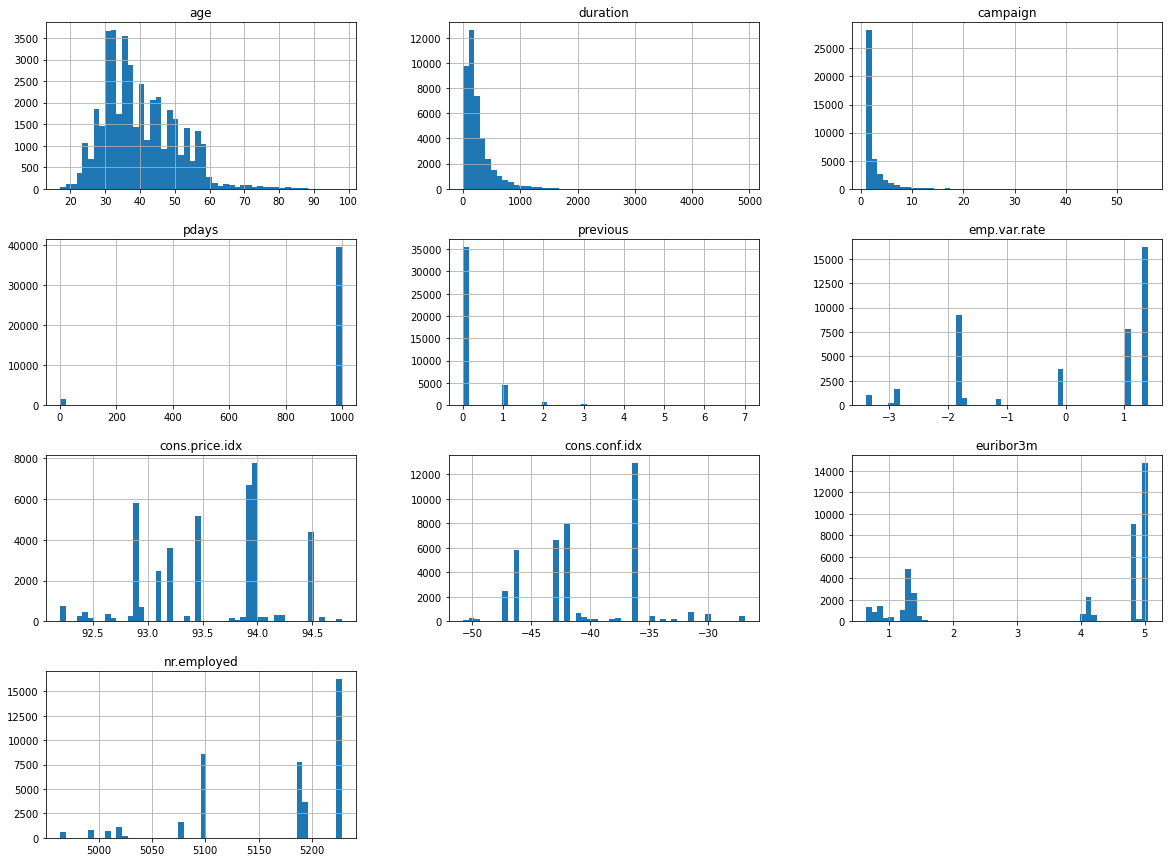

In [7]:
_ = df.hist(bins=50, figsize=(20,15))

In [8]:
# OneHotEncoder().fit_transform(df)
le = LabelEncoder()
df["y"] = le.fit_transform(df["y"])
df_dummies = pd.get_dummies(df)
df_dummies.drop('duration', axis=1)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,...,0,0,1,0,0,0,0,0,1,0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,...,0,0,1,0,0,0,0,0,1,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,...,0,0,1,0,0,0,0,0,1,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,...,0,0,1,0,0,0,0,0,1,0


In [9]:
df_dummies.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,...,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,...,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


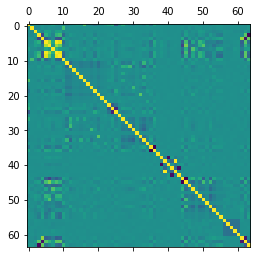

In [10]:
plt.matshow(df_dummies.corr())


In [11]:
#check for missing values
df_dummies.isnull().values.any()

False

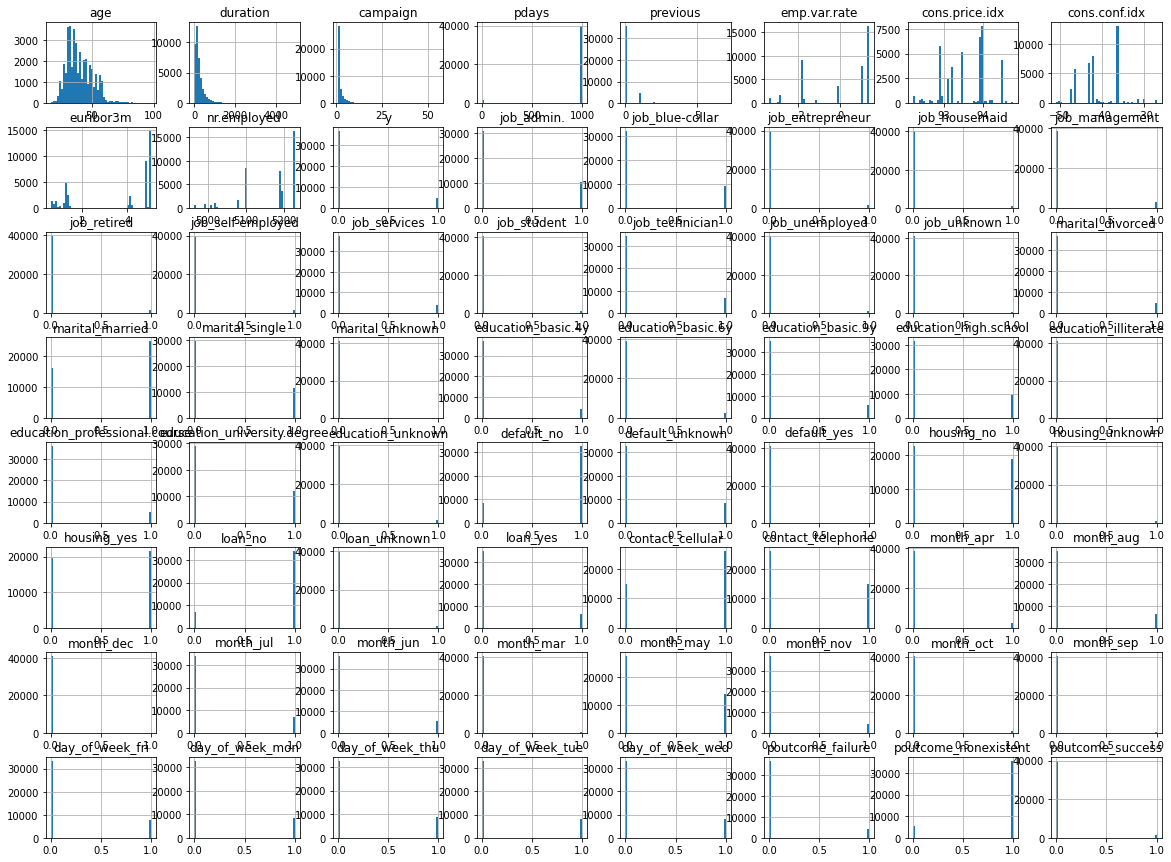

In [12]:
_ = df_dummies.hist(bins=50, figsize=(20,15))

0.11265417111780131


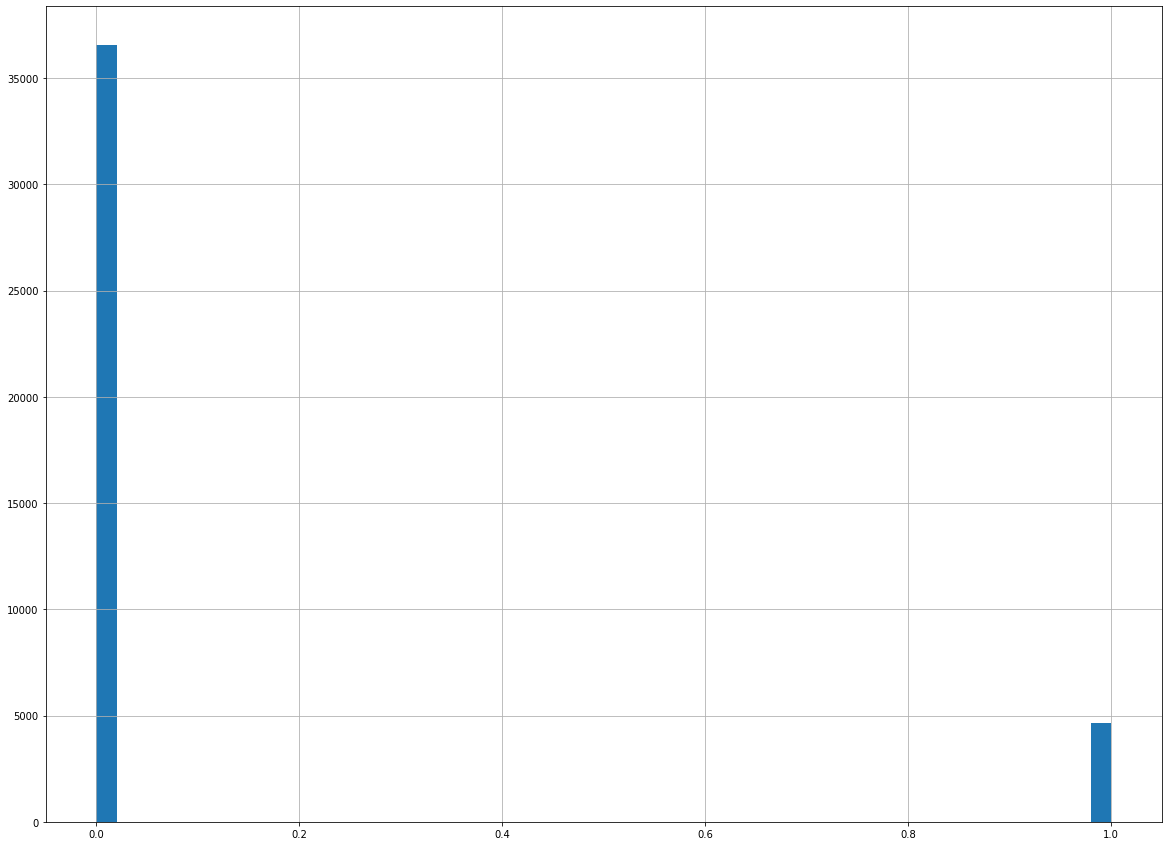

In [13]:
#check data imbalance...
imbalance_class = (df_dummies['y'].value_counts()[1]/len(df_dummies['y']))
print(imbalance_class)

_ = df_dummies["y"].hist(bins=50, figsize=(20,15))


In [14]:
state_df.loc[state_df['state'] == 'AK']

NameError: ignored

In [15]:
X_df = df_dummies.drop("y", axis=1)
X_df = X_df.drop("duration", axis=1)
# X_d = drop("y", axis=1)
print(X_df.columns)
Y_df = df_dummies["y"]
print(Y_df)

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_s

In [16]:
# Create separate training and test sets. we'll use the training set for steps 3--6
trainX, testX, trainY, testY = train_test_split(X_df, Y_df, test_size=0.2, random_state=50, stratify=Y_df)  
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(trainX), len(trainY))
trainY.value_counts()

32950 32950


0    29238
1     3712
Name: y, dtype: int64

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=750, max_depth=6)
dummy_clf = DummyClassifier(strategy='stratified') # generates predictions by respecting the training set's class distribution

scores = cross_val_score(clf, trainX, trainY, cv=10,scoring=make_scorer(f1_score))
# print("--------------Scores------------")
# print(scores)
dummy_scores = cross_val_score(dummy_clf, trainX, trainY, cv=10, scoring=make_scorer(f1_score))
# print("--------------Dummy scores-----------")
# print(dummy_scores)


print("F1 score: %0.2f +/- %0.2f" % (scores.mean(), scores.std()))
print("Dummy F1 score: %0.2f +/- %0.2f" % (dummy_scores.mean(), dummy_scores.std()))

F1 score: 0.28 +/- 0.05
Dummy F1 score: 0.11 +/- 0.01


In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10)
CV_rfc.fit(trainX, trainY)
print(CV_rfc.best_estimator_)
# print(CV_rfc.max_features)

RandomForestClassifier(max_depth=6, n_estimators=200)


In [30]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
clf1 = RandomForestClassifier(n_estimators=200, max_depth=6)
#dummy_clf1 = DummyClassifier(strategy='stratified') # generates predictions by respecting the training set's class distribution

scores1 = cross_val_score(clf1, trainX, trainY, cv=10,scoring=make_scorer(f1_score))
#dummy_scores1 = cross_val_score(dummy_clf1, trainX, trainY, cv=10, scoring=make_scorer(f1_score))


print("F1 score: %0.2f +/- %0.2f" % (scores1.mean(), scores1.std()))
#print("Dummy F1 score: %0.2f +/- %0.2f" % (dummy_scores1.mean(), dummy_scores1.std()))

F1 score: 0.28 +/- 0.04


In [ ]:
print(trainX.columns)

Feature ranking:
1. nr.employed (0.191106)
2. euribor3m (0.163341)
3. pdays (0.110659)
4. poutcome_success (0.093339)
5. emp.var.rate (0.082706)
6. cons.conf.idx (0.070032)
7. cons.price.idx (0.067957)
8. previous (0.027421)
9. age (0.022842)
10. month_mar (0.018991)
11. poutcome_nonexistent (0.017986)
12. month_oct (0.015871)
13. poutcome_failure (0.013776)
14. contact_telephone (0.013212)
15. contact_cellular (0.011930)
16. month_may (0.011012)
17. month_apr (0.007520)
18. campaign (0.004529)
19. default_no (0.003953)
20. day_of_week_mon (0.003841)
21. month_sep (0.003737)
22. month_jun (0.003690)
23. default_unknown (0.002973)
24. job_blue-collar (0.002441)
25. job_student (0.002408)
26. job_retired (0.001929)
27. education_university.degree (0.001866)
28. month_aug (0.001631)
29. month_dec (0.001561)
30. month_jul (0.001512)
31. day_of_week_thu (0.001399)
32. day_of_week_tue (0.001300)
33. marital_single (0.001297)
34. day_of_week_fri (0.001240)
35. day_of_week_wed (0.001240)
36. e

(0.0, 0.45813464752304045)

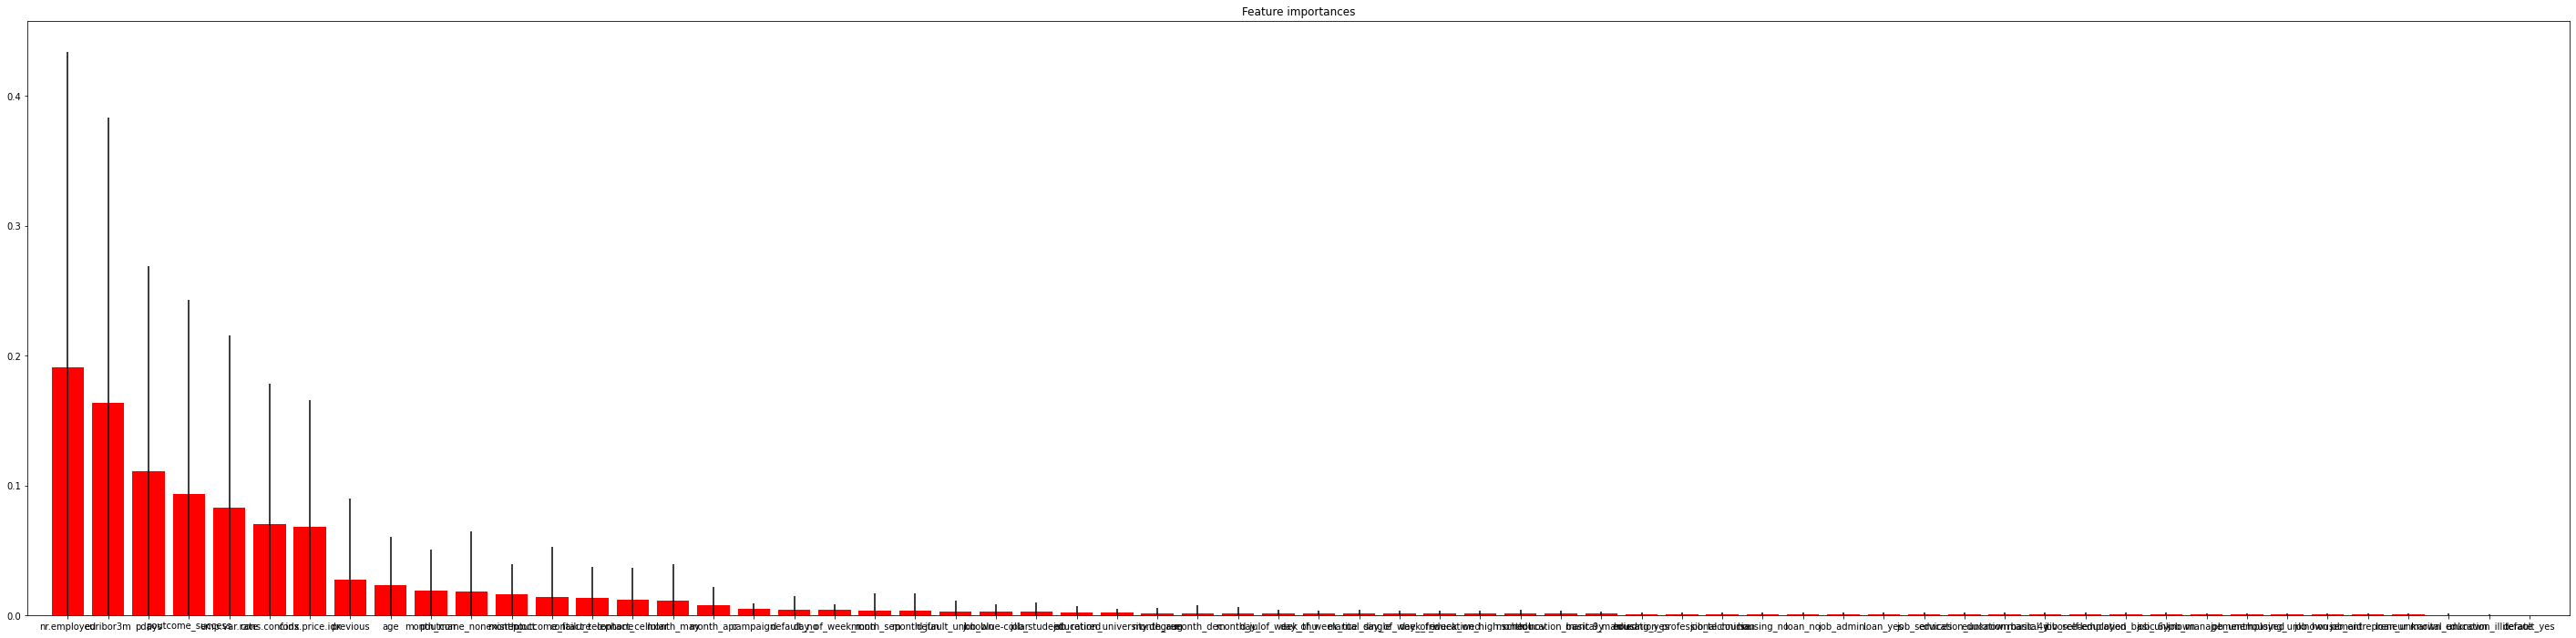

In [26]:
clf1.fit(trainX, trainY)
X = trainX
importances = clf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features = trainX.columns
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices])
plt.xlim([-1, X.shape[1]])
fig.set_size_inches(50, 12)
axes = plt.gca()
axes.set_ylim([0, None])

In [27]:
print("Top 3 features are follows: -")
for f in range(3):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Top 3 features are follows: -
1. nr.employed (0.191106)
2. euribor3m (0.163341)
3. pdays (0.110659)


Now using our classifier on the test data

In [ ]:
# Predict
test_predictions = clf.predict(testX)
# What's the accuracy on the test set?
f1_score(testY, test_predictions)
